In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import ggplot, aes, geom_point, geom_line
import ggplot as gg

import numpy as np
import pandas as pd
from itertools import product


from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeNormalPmf, EvalNormalPdf
import thinkplot

In [2]:
#Iris dataset
import pandas.rpy.common as rcom
iris = rcom.load_data('iris')
iris.head()

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  from ipykernel import kernelapp as app


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


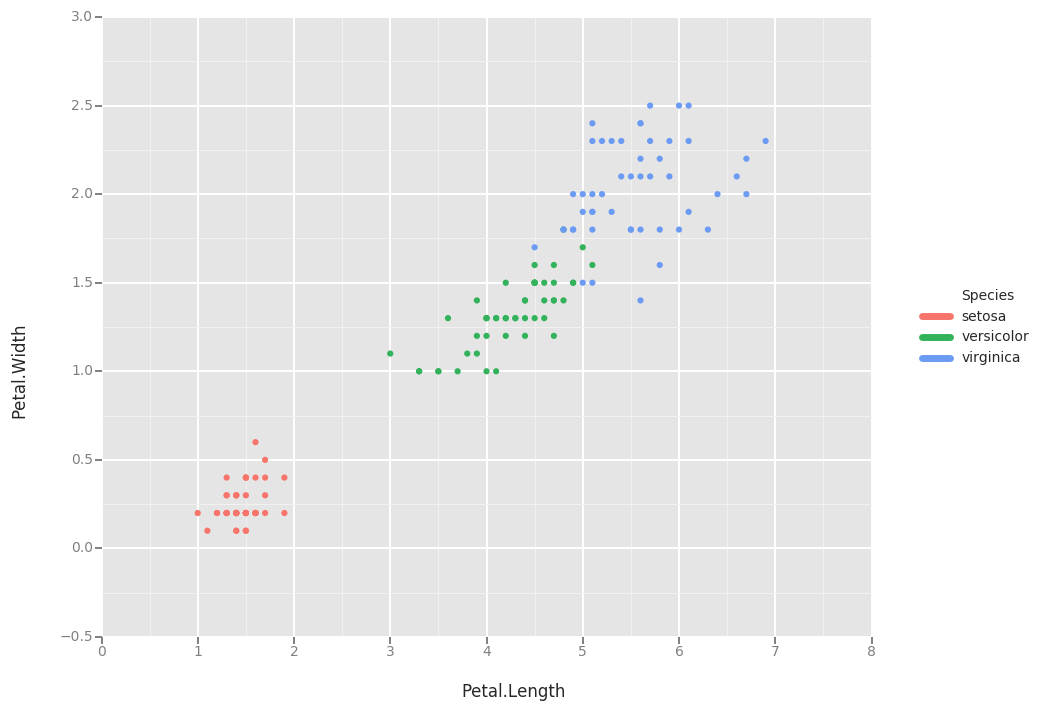

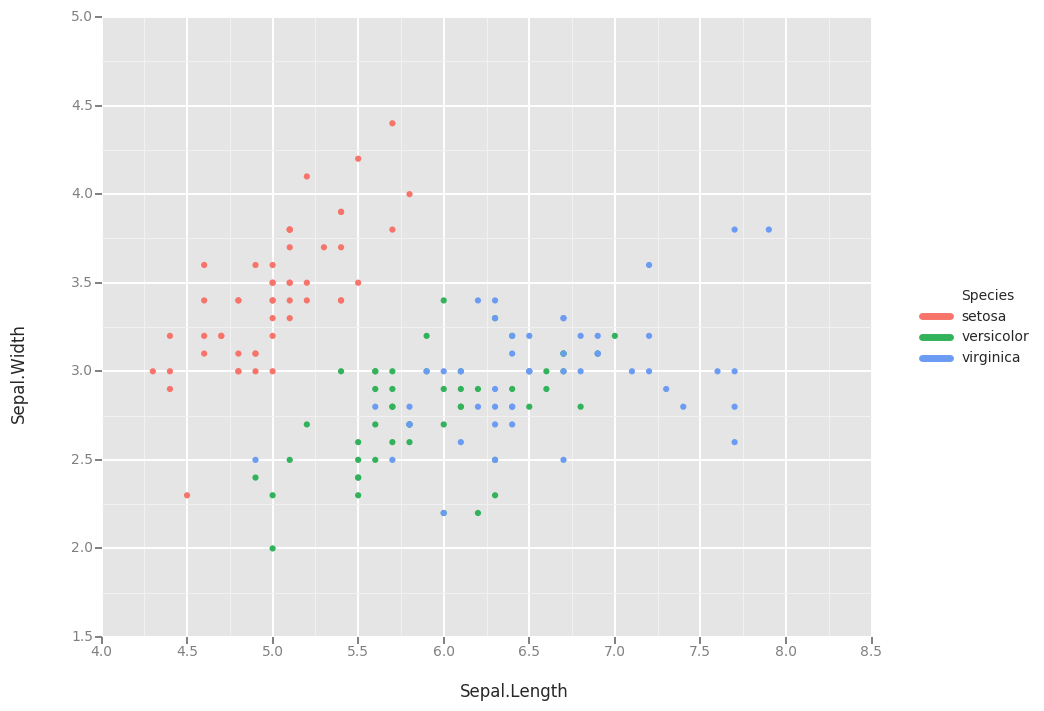

(<ggplot: (-9223363287663647421)>, <ggplot: (8749191128426)>)

In [3]:
#let's visualize the data
ptl_g = ggplot(iris,
               aes(x="Petal.Length",
                   y="Petal.Width",
                   color='Species')) +\
        geom_point()

spl_g = ggplot(iris,
               aes(x="Sepal.Length",
                   y="Sepal.Width",
                   color="Species")) +\
        geom_point()
ptl_g, spl_g

In [4]:
#Are the Petal.{Width, Height} well modeled by a normal distribution?
from scipy.stats import norm
#From chap09
class Normal(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: sequence of test scores
        hypo: mu, sigma
        """
        mu, sigma = hypo
        likes = norm.pdf(data, mu, sigma)
        return np.prod(likes)
    
def norm_dist_plots(df, attr="Petal", cols=["Width", "Length"], rows=False, faceted_plot=True, plot=True):
    #For lack of a mutliIndex
    colnames = [attr+"."+c for c in cols]
    
    #For K-fold
    if not rows:
        df = df.loc[:, colnames + ["Species"]]
    else:
        df = df.loc[rows, colnames + ["Species"]]
   
    if plot:
        if faceted_plot:
            thinkplot.PrePlot(rows=len(set(iris.Species)), cols=1)
            curr_plot = 1
    res_MAP = {}
    for spec, data in df.groupby("Species"):
        d = np.average((data[colnames]), axis=1)
        if plot:
            d_mus = np.linspace(0.5*np.average(d), 1.5*np.average(d), 40)
            d_sigmas = np.linspace(0.5*np.std(d), 1.5*np.std(d), 40)
            d_norm = Normal(product(d_mus, d_sigmas))
            d_norm.Update(d)
        res_MAP[spec] = (np.average(d), np.std(d))
        if plot:
            if faceted_plot:
                thinkplot.SubPlot(curr_plot)
                curr_plot += 1

            thinkplot.Contour(d_norm, cmap="terrain")
            if faceted_plot:
                thinkplot.Config(title="{}\nMAP: {}".format(spec, res_MAP[spec]),
                                 xlabel="$\mu$",
                                 ylabel="$\sigma$")
            else:
                thinkplot.Config(title="Normal distribution fit values")

            plt.tight_layout()
    return res_MAP

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


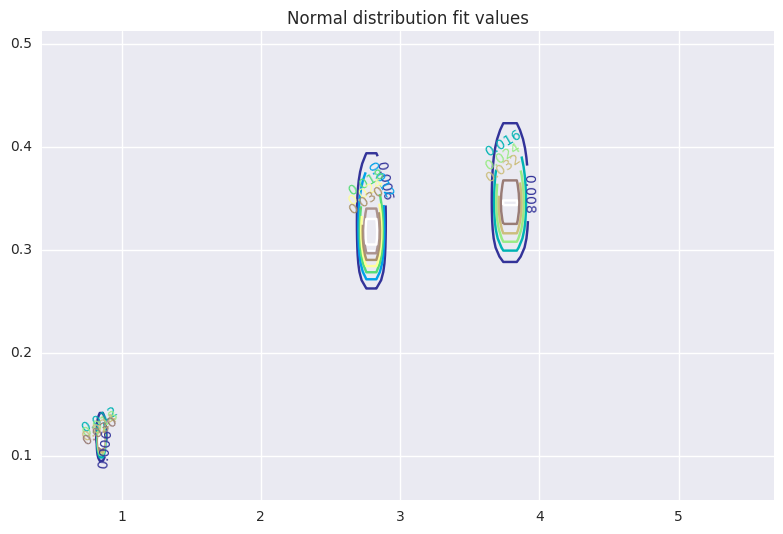

In [5]:
_ = norm_dist_plots(iris, faceted_plot=False)

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


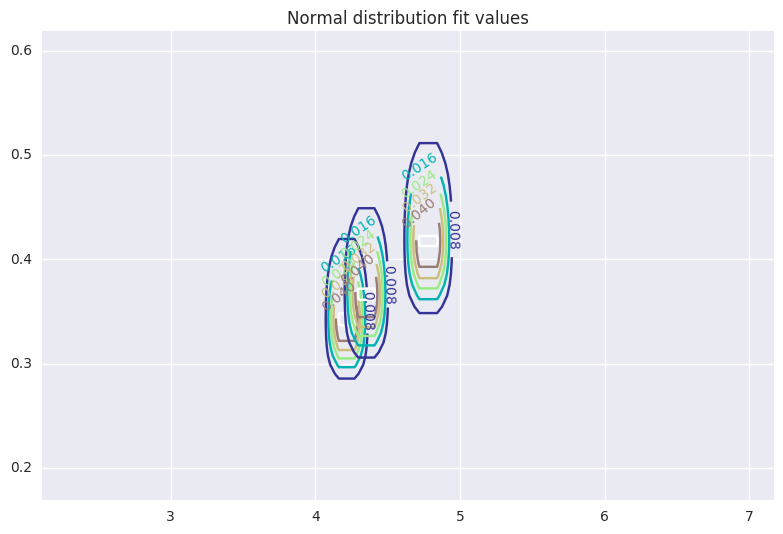

In [6]:
_ = norm_dist_plots(iris, attr="Sepal", faceted_plot=False)

From this we can infer that the Petals are a feature that we can classify off easily, so let's do that

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


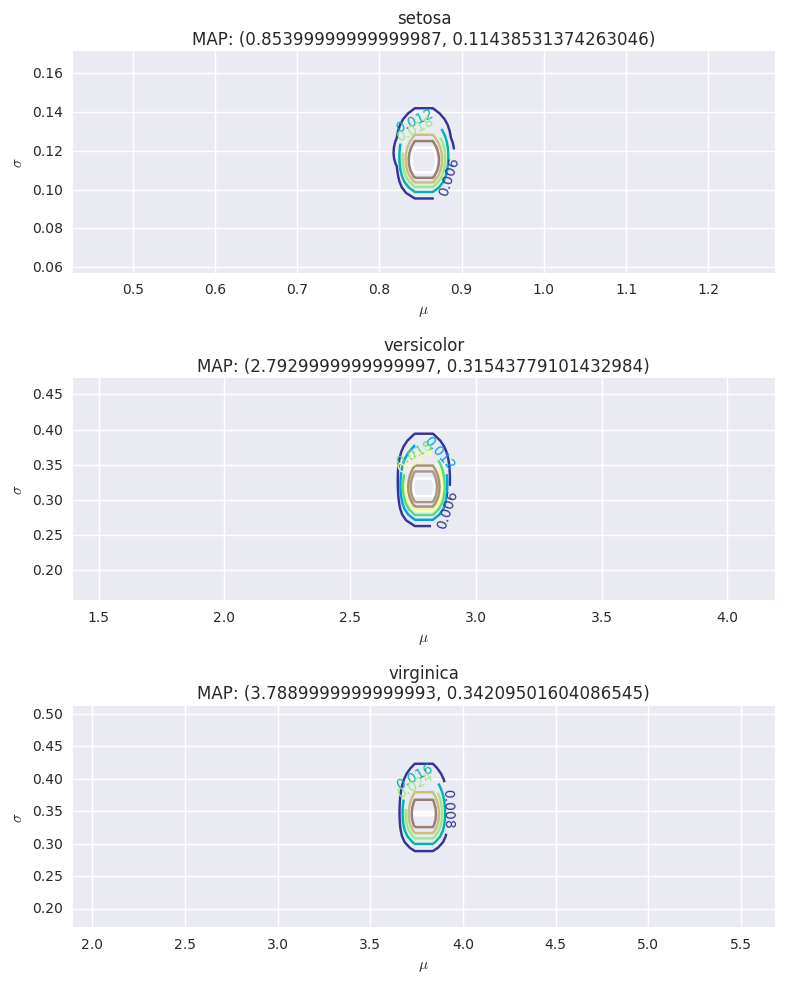

In [7]:
_ = norm_dist_plots(iris)

In [8]:
ratios = np.average(iris[["Petal.Width", "Petal.Length"]], axis=1)
MAPs = norm_dist_plots(iris, plot=False)
setosa_norm = ("setosa", lambda x: EvalNormalPdf(x, *MAPs['setosa']))
versicolor_norm = ("versicolor", lambda x: EvalNormalPdf(x, *MAPs['versicolor']))
virginica_norm = ("virginica", lambda x: EvalNormalPdf(x, *MAPs['virginica']))

In [9]:
def onehot(x, norms):
    evals = [x1 for _, x1 in norms]
    ress = []
    for i, n in enumerate(evals):
        ress.append(n(x))
    return norms[np.argmax(ress)][0]

In [10]:
norm_lst = [setosa_norm, versicolor_norm, virginica_norm]
iris["Predicted_muxed_inputs"] = list(map(lambda x: onehot(x, norm_lst), ratios))

How'd we do?

In [12]:
np.sum(iris.Species == iris.Predicted_muxed_inputs)/len(iris)

0.96666666666666667

Let's see how much the accuracy improves with data input

In [15]:
from sklearn.cross_validation import KFold

In [43]:
perfs = []
for n in range(2, len(iris)):
    test_perf = []
    for train, test in list(KFold(len(iris), n_folds=n, shuffle=True)):
        try:
            MAPs = norm_dist_plots(iris.ix[train], plot=False)
            setosa_norm = ("setosa", lambda x: EvalNormalPdf(x, *MAPs['setosa']))
            versicolor_norm = ("versicolor", lambda x: EvalNormalPdf(x, *MAPs['versicolor']))
            virginica_norm = ("virginica", lambda x: EvalNormalPdf(x, *MAPs['virginica']))

            norm_lst = [setosa_norm, versicolor_norm, virginica_norm]
            ratios = np.average(iris.loc[test, ["Petal.Width", "Petal.Length"]], axis=1)
            predicts = list(map(lambda x: onehot(x, norm_lst), ratios))

            test_perf.append(np.sum(predicts[0] == iris.ix[test].Species)/len(test))
        except:
            pass
    perfs.append(np.average(test_perf))

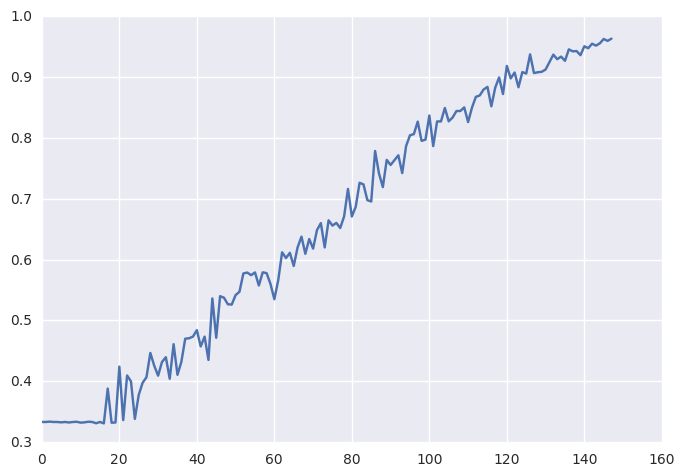

In [44]:
plt.plot(perfs)

We can see growth in the accuracy as it gets more data